In [253]:
# 우선, MNIST dataset에 적용할 transformation 객체를 생성합니다.
from torchvision import transforms
import torch
import copy

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


cuda


In [254]:
# transformation 정의하기
data_transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
])

In [255]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler


def get_train_valid_loader(data_dir,
                           batch_size,
                           random_seed,
                           augment=False,
                           valid_size=0.2,
                           shuffle=True,
                           num_workers=1,
                           pin_memory=True):
    """
    Utility function for loading and returning train and valid 
    multi-process iterators over the MNIST dataset. A sample 
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize((0.1307,), (0.3081,))  # MNIST

    '''
    # define transforms
    valid_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize
        ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize
        ])
    '''

    # load the dataset
    train_dataset = datasets.MNIST(root=data_dir, train=True, 
                download=True, transform=data_transform)

    valid_dataset = datasets.MNIST(root=data_dir, train=True, 
                download=True, transform=data_transform)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, 
                    batch_size=batch_size, sampler=train_sampler, 
                    num_workers=num_workers, pin_memory=pin_memory)

    valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                    batch_size=batch_size, sampler=valid_sampler, 
                    num_workers=num_workers, pin_memory=pin_memory)

    return (train_dataset, train_loader, valid_dataset, valid_loader)

In [256]:
# MNIST training dataset 불러오기
from torchvision import datasets

# 데이터를 저장할 경로 설정
path2data = './data'

# training data 불러오기
#train_data = datasets.MNIST(path2data, train=True, download=True, transform=data_transform)

# MNIST test dataset 불러오기
#val_data = datasets.MNIST(path2data, train=False, download=True, transform=data_transform)

In [257]:
# data loader 를 생성합니다.
from torch.utils.data import DataLoader

#train_dl = DataLoader(train_data, batch_size=32, shuffle=True)
#val_dl = DataLoader(val_data, batch_size=32)
train_data, train_dl, val_data, val_dl = get_train_valid_loader(path2data, 128, random_seed=np.random.seed(100), augment=False, valid_size=0.2, shuffle=True)

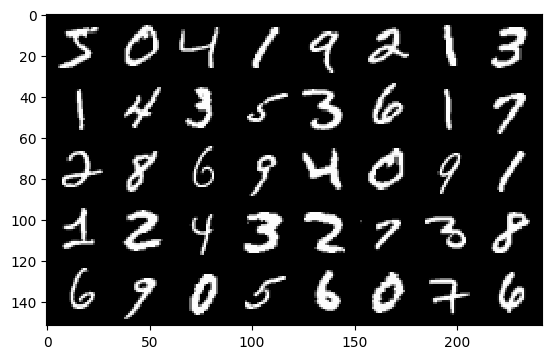

In [258]:
# sample images를 확인합니다.
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# training data를 추출합니다.
x_train, y_train = train_data.data, train_data.targets

# val data를 추출합니다.
x_val, y_val = val_data.data, val_data.targets

# 차원을 추가하여 B*C*H*W 가 되도록 합니다.
if len(x_train.shape) == 3:
    x_train = x_train.unsqueeze(1)

if len(x_val.shape) == 3:
    x_val = x_val.unsqueeze(1)

# tensor를 image로 변경하는 함수를 정의합니다.
def show(img):
    # tensor를 numpy array로 변경합니다.
    npimg = img.numpy()
    # C*H*W를 H*W*C로 변경합니다.
    npimg_tr = npimg.transpose((1,2,0))
    plt.imshow(npimg_tr, interpolation='nearest')

# images grid를 생성하고 출력합니다.
# 총 40개 이미지, 행당 8개 이미지를 출력합니다.
x_grid = utils.make_grid(x_train[:40], nrow=8, padding=2)

show(x_grid)

In [259]:
from skimage.util import random_noise
from torchvision.utils import save_image

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)



def save_noisy_image(img, name):
    if img.size(1) == 3:
        img = img.view(img.size(0), 3, 32, 32)
        save_image(img, name)
    else:
        img = img.view(img.size(0), 1, img.size(2), img.size(3))
        save_image(img, name)

def gaussian_noise(trainloader):
    for data in trainloader:
        img, _ = data[0], data[1]
        gauss_img = torch.tensor(random_noise(img, mode='gaussian', mean=0, var=0.05, clip=True))
        save_noisy_image(gauss_img, f"{path2data}/MNIST/gaussian_noise/MNIST_gaussian.png")
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


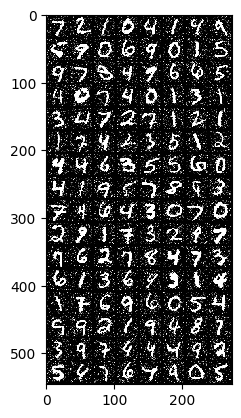

In [260]:

noisy_transform=transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(mean=0., std=0.6),
])

# MNIST test dataset 불러오기
test_data = datasets.MNIST(path2data, train=False, download=True, transform=noisy_transform)
test_dl = DataLoader(test_data, batch_size=128)
# test data를 추출합니다.
x_test, y_test = test_data.data, test_data.targets

if len(x_test.shape) == 3:
    x_test = x_test.unsqueeze(1)

for batch in test_dl:
    inputs, targets = (b.to(device) for b in batch)
    x_test_grid = utils.make_grid(inputs, nrow=8, padding=2)
    show(x_test_grid.to('cpu'))
    break


# 아래처럼 x_test로 접근하면 transform을 거치기 전 원본 데이터가 시각화 되므로 위의 코드처럼 순환하여 시각화하는 방식을 사용
#x_test_grid = utils.make_grid(x_test[:40], nrow=8, padding=2)
#show(x_test_grid)

In [261]:
from torch import nn
import torch.nn.functional as F

class LeNet_5(nn.Module):
    def __init__(self):
        super(LeNet_5,self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.tanh(self.conv1(x))
        x = F.avg_pool2d(x, 2, 2)
        x = F.tanh(self.conv2(x))
        x = F.avg_pool2d(x, 2, 2)
        x = F.tanh(self.conv3(x))
        x = x.view(-1, 120)
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)


In [262]:
def smooth_crossentropy(pred, gold, smoothing=0.1):
    n_class = pred.size(1)

    one_hot = torch.full_like(pred, fill_value=smoothing / (n_class - 1))
    one_hot.scatter_(dim=1, index=gold.unsqueeze(1), value=1.0 - smoothing)
    log_prob = F.log_softmax(pred, dim=1)

    return F.kl_div(input=log_prob, target=one_hot, reduction='none').sum(-1)

In [263]:
import argparse
import torch

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)    
from utility.log import Log
from utility.initialize import initialize
from utility.step_lr import StepLR
from utility.bypass_bn import enable_running_stats, disable_running_stats

import sys; sys.path.append("..")
from sam import SAM


args = dict()
args['adaptive'] = True
args['batch_size'] = 128
args['epochs'] = 100
args['label_smoothing'] = 0.1
args['learning_rate'] = 0.1
args['momentum'] = 0.9
args['threads'] = 2
args['rho'] = 2.0
args['weight_decay'] = 0.0005

initialize(args, seed=42)

log = Log(log_each=10)
model = LeNet_5().to(device)
print(model)

base_optimizer = torch.optim.SGD
optimizer = SAM(model.parameters(), base_optimizer, rho=args['rho'], adaptive=args['adaptive'], lr=args['learning_rate'], momentum=args['momentum'], weight_decay=args['weight_decay'])
scheduler = StepLR(optimizer, args['learning_rate'], args['epochs'])

for epoch in range(args['epochs']):
    model.train()
    log.train(len_dataset=len(train_dl))

    for batch in train_dl:
        inputs, targets = (b.to(device) for b in batch)

        # first forward-backward step
        enable_running_stats(model)
        predictions = model(inputs)
        loss = smooth_crossentropy(predictions, targets, smoothing=args['label_smoothing'])
        loss.mean().backward()
        optimizer.first_step(zero_grad=True)

        # second forward-backward step
        disable_running_stats(model)
        smooth_crossentropy(model(inputs), targets, smoothing=args['label_smoothing']).mean().backward()
        optimizer.second_step(zero_grad=True)

        with torch.no_grad():
            correct = torch.argmax(predictions.data, 1) == targets
            log(model, loss.cpu(), correct.cpu(), scheduler.lr())
            scheduler(epoch)

    model.eval()
    log.eval(len_dataset=len(val_dl))

    with torch.no_grad():
        for batch in val_dl:
            inputs, targets = (b.to(device) for b in batch)

            predictions = model(inputs)
            loss = smooth_crossentropy(predictions, targets)
            correct = torch.argmax(predictions, 1) == targets
            log(model, loss.cpu(), correct.cpu())

log.flush()

LeNet_5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)
┏━━━━━━━━━━━━━━┳━━━━━━━╸T╺╸R╺╸A╺╸I╺╸N╺━━━━━━━┳━━━━━━━╸S╺╸T╺╸A╺╸T╺╸S╺━━━━━━━┳━━━━━━━╸V╺╸A╺╸L╺╸I╺╸D╺━━━━━━━┓
┃              ┃              ╷              ┃              ╷              ┃              ╷              ┃
┃       epoch  ┃        loss  │    accuracy  ┃        l.r.  │     elapsed  ┃        loss  │    accuracy  ┃
┠──────────────╂──────────────┼──────────────╂──────────────┼──────────────╂──────────────┼──────────────┨
┃           0  ┃      1.3405  │     66.16 %  ┃   1.000e-01  │   00:11 min  ┃┈██████████████████████████▒┈┨      1.0926  │     92.20 %  ┃
┃           1  ┃      1.0772  │     93.86 %  ┃   1.000e-01  │   00:11 min  ┃┈██████████████████████████▒┈┨      1.0623  │ 

In [264]:
import os.path
if os.path.isfile(f'./model/epochs-{args['epochs']}/LeNet-5_SAM_b{args['batch_size']}.pth') == False:
    torch.save(model, f'./model/epochs-{args['epochs']}/LeNet-5_SAM_b{args['batch_size']}.pth')

In [265]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for batch in loader:
            x, y = (b.to(device) for b in batch)
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    

In [266]:
check_accuracy(test_dl, model)

Got 9832 / 10000 with accuracy 98.32
